## Full Repo
https://github.com/MostafaBelo/Konecta_Assignments/tree/main

## Imports

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from PIL import Image
import cv2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm

from typing import Literal

## Constants and Utils

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Exploration

In [3]:
df = pd.read_csv("Dataset/sports.csv")
len(df[df["data set"] == "train"]), len(df[df["data set"] == "valid"]), len(df[df["data set"] == "test"])

(13492, 500, 500)

In [4]:
class_names = df.groupby("class id")["labels"].unique()
id_to_name = {i:v[0] for i,v in enumerate(class_names)}
id_name_list = [v[0] for v in class_names]

# id_to_name
id_name_list

['air hockey',
 'ampute football',
 'archery',
 'arm wrestling',
 'axe throwing',
 'balance beam',
 'barell racing',
 'baseball',
 'basketball',
 'baton twirling',
 'bike polo',
 'billiards',
 'bmx',
 'bobsled',
 'bowling',
 'boxing',
 'bull riding',
 'bungee jumping',
 'canoe slamon',
 'cheerleading',
 'chuckwagon racing',
 'cricket',
 'croquet',
 'curling',
 'disc golf',
 'fencing',
 'field hockey',
 'figure skating men',
 'figure skating pairs',
 'figure skating women',
 'fly fishing',
 'football',
 'formula 1 racing',
 'frisbee',
 'gaga',
 'giant slalom',
 'golf',
 'hammer throw',
 'hang gliding',
 'harness racing',
 'high jump',
 'hockey',
 'horse jumping',
 'horse racing',
 'horseshoe pitching',
 'hurdles',
 'hydroplane racing',
 'ice climbing',
 'ice yachting',
 'jai alai',
 'javelin',
 'jousting',
 'judo',
 'lacrosse',
 'log rolling',
 'luge',
 'motorcycle racing',
 'mushing',
 'nascar racing',
 'olympic wrestling',
 'parallel bar',
 'pole climbing',
 'pole dancing',
 'pole vau

(69, 201, np.float64(144.92), 143.5)

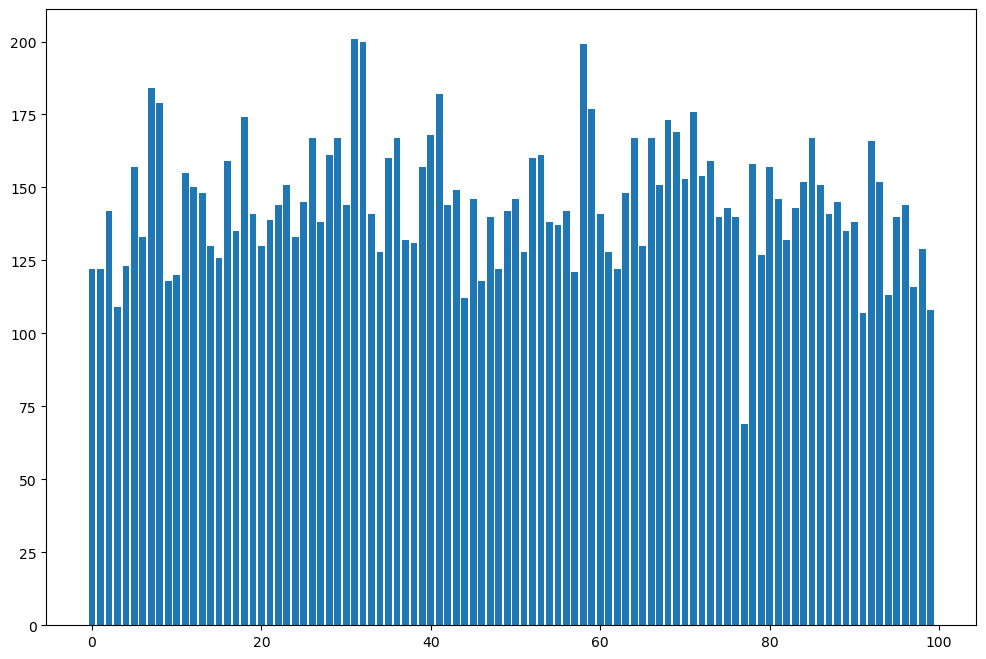

In [5]:
counts = df.groupby("class id").count()["labels"]

# Generally comparable counts
plt.figure(figsize=(12,8))
plt.bar(range(100), counts);

counts.min(), counts.max(), counts.mean(), counts.median()

In [6]:
y = df[df["data set"] == "train"]["class id"]
class_weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.linspace(0,99, 100),
    y=y
)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
class_weights

tensor([1.2046, 1.2046, 1.0221, 1.3628, 1.1940, 0.9178, 1.0969, 0.7754, 0.7983,
        1.2493, 1.2265, 0.9305, 0.9637, 0.9777, 1.1243, 1.1631, 0.9055, 1.0794,
        0.8227, 1.0299, 1.1243, 1.0459, 1.0069, 0.9569, 1.0969, 0.9994, 0.8594,
        1.0541, 0.8935, 0.8594, 1.0069, 0.7064, 0.7101, 1.0299, 1.1434, 0.8995,
        0.8594, 1.1059, 1.1150, 0.9178, 0.8539, 0.7844, 1.0069, 0.9706, 1.3227,
        0.9921, 1.2493, 1.0378, 1.2046, 1.0221, 0.9921, 1.1434, 0.8995, 0.8935,
        1.0541, 1.0624, 1.0221, 1.2155, 0.7139, 0.8079, 1.0299, 1.1434, 1.2046,
        0.9777, 0.8594, 1.1243, 0.8594, 0.9569, 0.8277, 0.8486, 0.9435, 0.8128,
        0.9369, 0.9055, 1.0378, 1.0144, 1.0378, 2.2868, 0.9116, 1.1532, 0.9178,
        0.9921, 1.1059, 1.0144, 0.9501, 0.8594, 0.9569, 1.0299, 0.9994, 1.0794,
        1.0541, 1.3909, 0.8649, 0.9501, 1.3099, 1.0378, 1.0069, 1.2728, 1.1338,
        1.3767], device='cuda:0')

## Dataset

In [8]:
class SportsDataset(Dataset):
    def __init__(self, root_dir, dataset_group: Literal["train", "valid", "test"], labels_file="sports.csv", transform=None, target_transform=None):
        self.root_dir = root_dir
        self.dataset_group = dataset_group

        self.labels = pd.read_csv(os.path.join(self.root_dir, labels_file))

        self.labels = self.labels[self.labels["data set"] == self.dataset_group]

        # if transform is not None:
        #     self.transform = transform
        # else:
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            *([transform] if transform else []),
        ])
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.labels)
    
    def __getitem__(self, idx: int):
        img_path = os.path.join(self.root_dir, self.labels.iloc[idx]["filepaths"])
        img = Image.open(img_path).convert("RGB")

        label = self.labels.iloc[idx]["class id"]

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            label = self.target_transform(label)

        return img, label
    
    def getLoader(self, batch_size=64, num_workers=4):
        if num_workers > 0:
            return DataLoader(self, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2, persistent_workers=True)
        return DataLoader(self, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [9]:
root_dir = "Dataset"
train_dataset = SportsDataset(root_dir, "train")
valid_dataset = SportsDataset(root_dir, "valid")
test_dataset = SportsDataset(root_dir, "test")


train_loader = train_dataset.getLoader()
valid_loader = valid_dataset.getLoader()
test_loader = test_dataset.getLoader()

len(train_dataset), len(valid_dataset), len(test_dataset)

(13492, 500, 500)

torch.Size([64, 3, 224, 224]) torch.Size([64]) <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.float32 torch.int64 tensor(1.) tensor(0.)


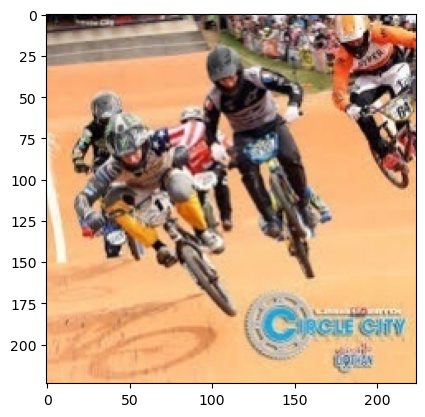

In [11]:
for X, y in train_loader:
    print(X.shape, y.shape, type(X), type(y))
    print(X.dtype, y.dtype, X.max(), X.min())
    plt.imshow(X[0].permute(1,2,0));
    break

## Utils

In [12]:
def train(model: nn.Module, train_loader: DataLoader, valid_loader: DataLoader, epochs:int=30, lr:float=1e-3, save_file_name=""):
    model = model.to(device)

    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    best_valid = None
    os.makedirs("models", exist_ok=True)

    train_tracked_losses = []
    train_tracked_acc = []
    valid_tracked_losses = []
    valid_tracked_acc = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        # Training
        model.train()
        
        train_loss = 0.0
        train_correct = 0
        train_count = 0
        for X,y in tqdm(train_loader, desc="Train"):
            X: torch.Tensor = X.to(device)
            y: torch.Tensor = y.to(device)
            B = X.shape[0]
            
            y_preds: torch.Tensor = model(X)

            optim.zero_grad()
            loss: torch.Tensor = loss_fn(y_preds, y)
            loss.backward()
            optim.step()

            train_loss += loss.item()
            train_correct += (y_preds.softmax(dim=1).argmax(dim=1) == y).sum().item()
            train_count += B
        train_loss /= train_count
        train_acc = train_correct / train_count

        # Validation
        model.eval()

        valid_loss = 0.0
        valid_correct = 0
        valid_count = 0
        for X,y in tqdm(valid_loader, desc="Valid"):
            X: torch.Tensor = X.to(device)
            y: torch.Tensor = y.to(device)
            B = X.shape[0]
            
            with torch.inference_mode():
                y_preds: torch.Tensor = model(X)

            loss: torch.Tensor = loss_fn(y_preds, y)

            valid_loss += loss.item()
            valid_correct += (y_preds.softmax(dim=1).argmax(dim=1) == y).sum().item()
            valid_count += B
        valid_loss /= valid_count
        valid_acc = valid_correct / valid_count

        train_tracked_losses.append(train_loss)
        train_tracked_acc.append(train_acc)
        valid_tracked_losses.append(valid_loss)
        valid_tracked_acc.append(valid_acc)

        # Logging
        if (epoch+1) % 1 == 0:
            print(f"Epoch {epoch+1} | Train {train_loss:.6f} {train_acc*1e2:.4f}% | Valid {valid_loss:.6f} {valid_acc*1e2:.4f}%")

        if best_valid is None or valid_loss < best_valid:
            best_valid = valid_loss
            model_path = f"models/{save_file_name}_best.pt" if save_file_name != "" else "models/best.pt"
            torch.save(model.state_dict(), model_path)

        torch.cuda.empty_cache()
    
    model_path = f"models/{save_file_name}_last.pt" if save_file_name != "" else f"models/last.pt"
    torch.save(model.state_dict(), model_path)

    plt.figure(figsize=(12,8));
    plt.subplot(1,2,1);
    plt.plot(train_tracked_losses);
    plt.plot(valid_tracked_losses);
    plt.subplot(1,2,2);
    plt.plot(train_tracked_acc);
    plt.plot(valid_tracked_acc);

In [13]:
def test(model: nn.Module, test_loader: DataLoader):
    model = model.to(device)

    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    
    test_loss = 0.0
    test_count = 0

    all_preds = []
    all_labels = []

    for X, y in tqdm(test_loader):
        X: torch.Tensor = X.to(device)
        y: torch.Tensor = y.to(device)
        B = X.shape[0]
        
        with torch.inference_mode():
            y_preds: torch.Tensor = model(X)

        loss: torch.Tensor = loss_fn(y_preds, y)

        all_preds.append(y_preds.softmax(dim=1).argmax(dim=1))
        all_labels.append(y)

        test_loss += loss.item()
        test_count += B
    test_loss /= test_count

    all_preds = torch.cat(all_preds, dim=0).cpu()
    all_labels = torch.cat(all_labels, dim=0).cpu()

    print(f"Loss: {test_loss:.6f}")
    print(classification_report(all_labels, all_preds))
    
    plt.figure(figsize=(16,16));
    cm = confusion_matrix(all_labels, all_preds)
    # disp = ConfusionMatrixDisplay(cm, display_labels=id_name_list)
    disp = ConfusionMatrixDisplay(cm, display_labels=range(100))
    disp.plot();

## Model Simple Architecture

In [ ]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        dropprob = 0.25

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(dropprob),
        )

        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(32*7*7, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropprob),

            nn.Linear(512, 100)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_blocks(x)
        x = self.classifier_head(x)
        return x

In [ ]:
model = ClassifierModel().to(device)
model

ClassifierModel(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): 

In [ ]:
sum(param.numel() for param in model.parameters())

860772

Epoch 1


Valid: 100%|██████████| 8/8 [00:00<00:00, 12.14it/s]


Epoch 1 | Train 0.059039 12.3777% | Valid 0.049196 21.8000%
Epoch 2


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.61it/s]


Epoch 2 | Train 0.044323 28.8023% | Valid 0.043851 31.6000%
Epoch 3


Valid: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Epoch 3 | Train 0.036992 38.2523% | Valid 0.038619 35.8000%
Epoch 4


Valid: 100%|██████████| 8/8 [00:00<00:00, 15.85it/s]


Epoch 4 | Train 0.031843 45.4862% | Valid 0.042741 33.8000%
Epoch 5


Valid: 100%|██████████| 8/8 [00:00<00:00, 16.92it/s]


Epoch 5 | Train 0.027580 51.7269% | Valid 0.037187 41.2000%
Epoch 6


Valid: 100%|██████████| 8/8 [00:00<00:00, 12.83it/s]


Epoch 6 | Train 0.024004 56.7818% | Valid 0.036478 47.8000%
Epoch 7


Valid: 100%|██████████| 8/8 [00:00<00:00,  9.19it/s]


Epoch 7 | Train 0.020904 61.4586% | Valid 0.034095 49.4000%
Epoch 8


Valid: 100%|██████████| 8/8 [00:00<00:00, 15.36it/s]


Epoch 8 | Train 0.018529 64.8532% | Valid 0.033200 47.2000%
Epoch 9


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.38it/s]


Epoch 9 | Train 0.016593 68.8853% | Valid 0.043333 44.0000%
Epoch 10


Valid: 100%|██████████| 8/8 [00:00<00:00,  8.87it/s]


Epoch 10 | Train 0.015115 70.1823% | Valid 0.035640 50.4000%
Epoch 11


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.28it/s]


Epoch 11 | Train 0.013491 73.0729% | Valid 0.034426 49.8000%
Epoch 12


Valid: 100%|██████████| 8/8 [00:00<00:00, 10.25it/s]


Epoch 12 | Train 0.012263 75.5929% | Valid 0.036997 48.2000%
Epoch 13


Valid: 100%|██████████| 8/8 [00:00<00:00, 13.28it/s]


Epoch 13 | Train 0.011063 78.1945% | Valid 0.036141 50.8000%
Epoch 14


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.31it/s]


Epoch 14 | Train 0.010675 78.3205% | Valid 0.038649 48.2000%
Epoch 15


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.51it/s]


Epoch 15 | Train 0.009906 79.7213% | Valid 0.038668 49.8000%
Epoch 16


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.56it/s]


Epoch 16 | Train 0.009041 81.9078% | Valid 0.040153 51.2000%
Epoch 17


Valid: 100%|██████████| 8/8 [00:00<00:00, 14.39it/s]


Epoch 17 | Train 0.008706 82.4192% | Valid 0.047117 48.0000%
Epoch 18


Valid: 100%|██████████| 8/8 [00:00<00:00, 15.81it/s]


Epoch 18 | Train 0.008149 83.4791% | Valid 0.037399 51.6000%
Epoch 19


Valid: 100%|██████████| 8/8 [00:00<00:00, 13.54it/s]


Epoch 19 | Train 0.008197 82.8713% | Valid 0.042264 49.0000%
Epoch 20


Valid: 100%|██████████| 8/8 [00:00<00:00, 13.80it/s]


Epoch 20 | Train 0.007696 84.1462% | Valid 0.042014 51.0000%


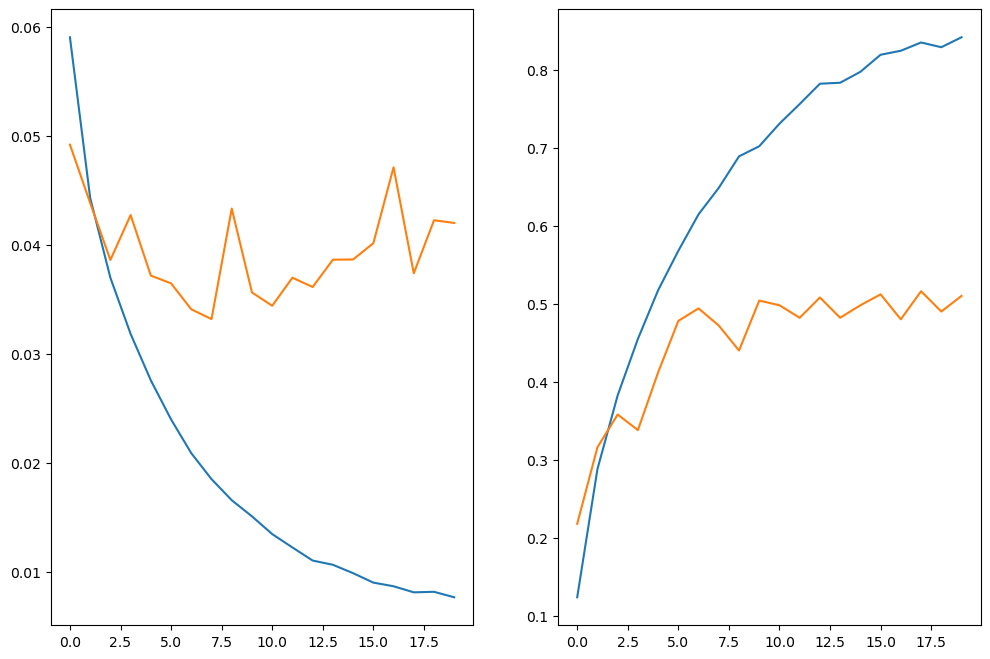

In [ ]:
train(model, train_loader, valid_loader, epochs=20, lr=1e-3, save_file_name="simple")

100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


Loss: 0.031946
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      0.20      0.33         5
           2       0.50      0.40      0.44         5
           3       0.62      1.00      0.77         5
           4       1.00      0.60      0.75         5
           5       0.44      0.80      0.57         5
           6       0.40      0.80      0.53         5
           7       0.00      0.00      0.00         5
           8       1.00      0.20      0.33         5
           9       0.00      0.00      0.00         5
          10       0.30      0.60      0.40         5
          11       0.83      1.00      0.91         5
          12       0.14      0.40      0.21         5
          13       0.00      0.00      0.00         5
          14       1.00      0.40      0.57         5
          15       1.00      0.60      0.75         5
          16       0.36      1.00      0.53         5
          17

<Figure size 1600x1600 with 0 Axes>

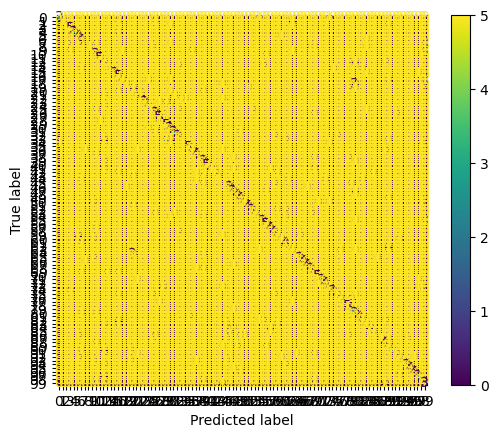

In [ ]:
model.load_state_dict(torch.load("models/simple_best.pt"))
test(model, test_loader)

## Model Global Avg Pooling

In [ ]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        dropprob = 0.25

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(16, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(64, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(dropprob),

            nn.AdaptiveAvgPool2d((1,1))
        )

        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropprob),

            nn.Linear(512, 100)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_blocks(x)
        x = self.classifier_head(x)
        return x

In [ ]:
model = ClassifierModel().to(device)
model

ClassifierModel(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
sum(param.numel() for param in model.parameters())

970324

Epoch 1


Valid: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]


Epoch 1 | Train 0.057815 10.8731% | Valid 0.052093 15.8000%
Epoch 2


Valid: 100%|██████████| 8/8 [00:00<00:00,  8.88it/s]


Epoch 2 | Train 0.045829 23.9846% | Valid 0.047366 24.4000%
Epoch 3


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]


Epoch 3 | Train 0.038797 34.1832% | Valid 0.032787 46.2000%
Epoch 4


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 4 | Train 0.033196 42.6771% | Valid 0.032456 44.8000%
Epoch 5


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]


Epoch 5 | Train 0.029009 48.9623% | Valid 0.027831 53.8000%
Epoch 6


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


Epoch 6 | Train 0.025228 54.7584% | Valid 0.025687 54.6000%
Epoch 7


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 7 | Train 0.022412 59.4352% | Valid 0.028822 52.2000%
Epoch 8


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]


Epoch 8 | Train 0.019925 63.5414% | Valid 0.022366 64.0000%
Epoch 9


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 9 | Train 0.017597 66.7581% | Valid 0.022716 57.4000%
Epoch 10


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]


Epoch 10 | Train 0.015793 69.7821% | Valid 0.020446 63.6000%
Epoch 11


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 11 | Train 0.014322 72.3169% | Valid 0.018003 67.6000%
Epoch 12


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]


Epoch 12 | Train 0.012540 76.0599% | Valid 0.018266 68.6000%
Epoch 13


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


Epoch 13 | Train 0.011260 78.0388% | Valid 0.020143 68.6000%
Epoch 14


Valid: 100%|██████████| 8/8 [00:02<00:00,  4.00it/s]


Epoch 14 | Train 0.009777 80.4254% | Valid 0.017759 71.2000%
Epoch 15


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]


Epoch 15 | Train 0.009227 81.3667% | Valid 0.018367 70.6000%
Epoch 16


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]


Epoch 16 | Train 0.008117 83.3605% | Valid 0.019738 71.2000%
Epoch 17


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]


Epoch 17 | Train 0.007550 84.2055% | Valid 0.017773 71.6000%
Epoch 18


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]


Epoch 18 | Train 0.006861 86.4809% | Valid 0.015098 74.8000%
Epoch 19


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


Epoch 19 | Train 0.006018 87.4666% | Valid 0.016141 73.6000%
Epoch 20


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]


Epoch 20 | Train 0.005494 88.7859% | Valid 0.016207 74.6000%


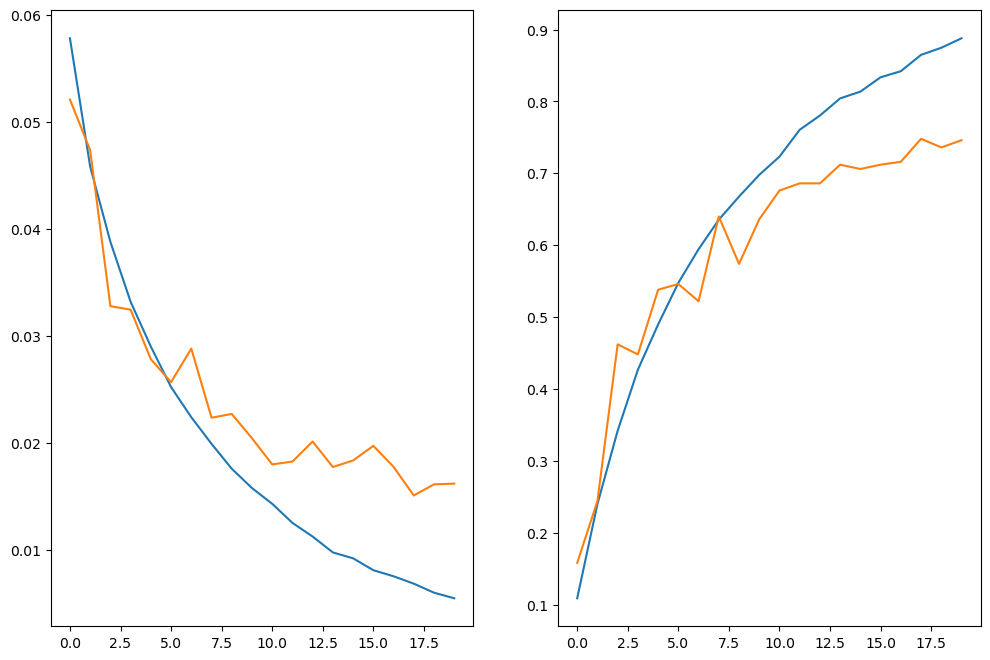

In [ ]:
train(model, train_loader, valid_loader, epochs=20, lr=1e-3, save_file_name="global")

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


Loss: 0.014941
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.75      0.60      0.67         5
           2       0.80      0.80      0.80         5
           3       0.80      0.80      0.80         5
           4       0.67      0.80      0.73         5
           5       0.80      0.80      0.80         5
           6       1.00      0.60      0.75         5
           7       0.75      0.60      0.67         5
           8       0.80      0.80      0.80         5
           9       0.33      0.40      0.36         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.40      0.57         5
          13       0.80      0.80      0.80         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         5
          16       0.71      1.00      0.83         5
          17

<Figure size 1600x1600 with 0 Axes>

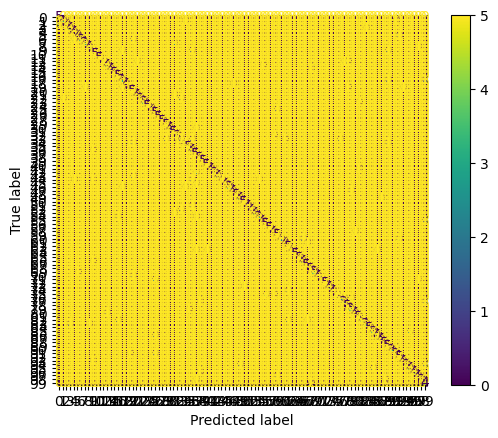

In [ ]:
model.load_state_dict(torch.load("models/global_best.pt"))
test(model, test_loader)

## Model multi Global Avg Pooling

In [ ]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        dropprob = 0.25

        img_size = torch.tensor([224,224], dtype=torch.int32)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.AdaptiveAvgPool2d(img_size//4),
            # nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(16, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.AdaptiveAvgPool2d(img_size//16),
            # nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(64, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(img_size//32),
            # nn.MaxPool2d(2),
            nn.Dropout(dropprob),

            nn.AdaptiveAvgPool2d((1,1))
        )

        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropprob),

            nn.Linear(512, 100)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_blocks(x)
        x = self.classifier_head(x)
        return x

In [ ]:
model = ClassifierModel().to(device)
model

ClassifierModel(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): AdaptiveAvgPool2d(output_size=tensor([56, 56], dtype=torch.int32))
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): AdaptiveAvgPool2d(output_size=tensor([14, 14], dtype=torch.int32))
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [ ]:
sum(param.numel() for param in model.parameters())

970324

Epoch 1


Valid: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


Epoch 1 | Train 0.058977 10.3988% | Valid 0.052981 16.2000%
Epoch 2


Valid: 100%|██████████| 8/8 [00:00<00:00, 10.85it/s]


Epoch 2 | Train 0.050015 19.3670% | Valid 0.055496 15.8000%
Epoch 3


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.01it/s]


Epoch 3 | Train 0.045054 25.2372% | Valid 0.046568 24.8000%
Epoch 4


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]


Epoch 4 | Train 0.040649 31.5669% | Valid 0.051150 21.4000%
Epoch 5


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.87it/s]


Epoch 5 | Train 0.036683 37.5334% | Valid 0.037130 39.2000%
Epoch 6


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 6 | Train 0.033276 42.2917% | Valid 0.035898 41.6000%
Epoch 7


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]


Epoch 7 | Train 0.030484 46.6647% | Valid 0.029806 51.4000%
Epoch 8


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


Epoch 8 | Train 0.027582 50.9784% | Valid 0.027474 54.6000%
Epoch 9


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]


Epoch 9 | Train 0.024746 55.1883% | Valid 0.028273 49.2000%
Epoch 10


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 10 | Train 0.022316 59.1313% | Valid 0.024369 55.8000%
Epoch 11


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]


Epoch 11 | Train 0.020551 62.4074% | Valid 0.023016 61.0000%
Epoch 12


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]


Epoch 12 | Train 0.018748 65.3054% | Valid 0.024407 57.2000%
Epoch 13


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


Epoch 13 | Train 0.017378 67.4326% | Valid 0.022074 60.0000%
Epoch 14


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


Epoch 14 | Train 0.015370 70.9680% | Valid 0.021243 64.2000%
Epoch 15


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]


Epoch 15 | Train 0.014258 72.6727% | Valid 0.021117 62.8000%
Epoch 16


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


Epoch 16 | Train 0.013365 74.3403% | Valid 0.022266 62.4000%
Epoch 17


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]


Epoch 17 | Train 0.011868 76.7862% | Valid 0.020249 65.6000%
Epoch 18


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.24it/s]


Epoch 18 | Train 0.011084 78.2908% | Valid 0.020612 67.4000%
Epoch 19


Valid: 100%|██████████| 8/8 [00:01<00:00,  4.26it/s]


Epoch 19 | Train 0.009927 80.6256% | Valid 0.018414 69.6000%
Epoch 20


Valid: 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]


Epoch 20 | Train 0.009297 81.4334% | Valid 0.018826 68.6000%


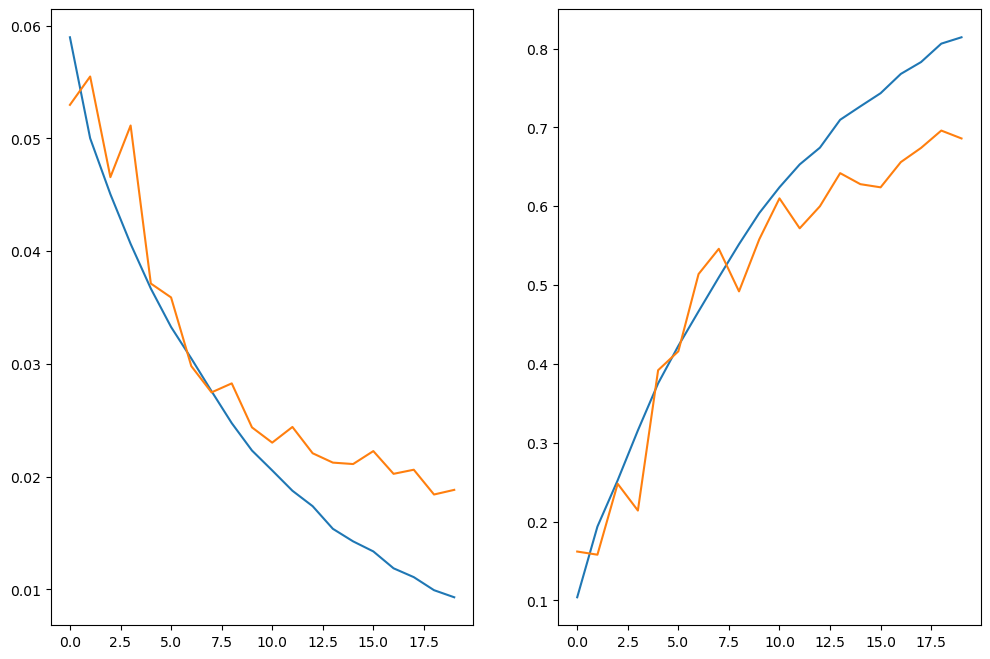

In [ ]:
train(model, train_loader, valid_loader, epochs=20, lr=1e-3, save_file_name="multi_global")

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Loss: 0.016569
              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       0.50      0.80      0.62         5
           2       0.40      0.40      0.40         5
           3       0.50      0.80      0.62         5
           4       0.57      0.80      0.67         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       0.00      0.00      0.00         5
           8       0.50      0.40      0.44         5
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.40      0.57         5
          13       0.50      0.60      0.55         5
          14       0.60      0.60      0.60         5
          15       1.00      0.80      0.89         5
          16       0.40      0.80      0.53         5
          17

<Figure size 1600x1600 with 0 Axes>

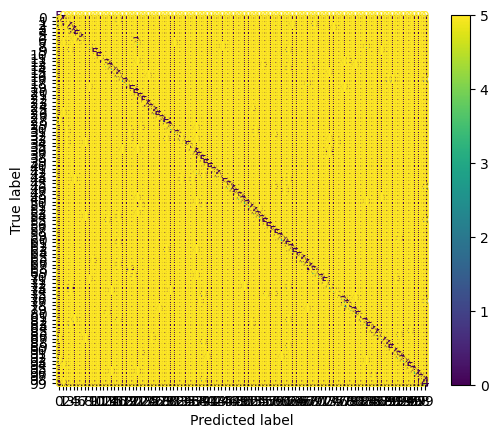

In [ ]:
model.load_state_dict(torch.load("models/multi_global_best.pt"))
test(model, test_loader)

## Model Augmented Dataset

In [14]:
root_dir = "Dataset"

transform_fn = transforms.Compose([
    transforms.RandomResizedCrop((224,224), scale=(0.7, 1.0)),  # random zoom/crop
    transforms.RandomHorizontalFlip(p=0.5),                      # mirror
    transforms.RandomRotation(degrees=15),                       # small rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, 
                           saturation=0.3, hue=0.1),             # color variations
])

train_dataset = SportsDataset(root_dir, "train", transform=transform_fn)
valid_dataset = SportsDataset(root_dir, "valid")
test_dataset = SportsDataset(root_dir, "test")


train_loader = train_dataset.getLoader()
valid_loader = valid_dataset.getLoader()
test_loader = test_dataset.getLoader()

len(train_dataset), len(valid_dataset), len(test_dataset)

(13492, 500, 500)

In [15]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        dropprob = 0.25

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(16, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(4),
            nn.Dropout(dropprob),

            nn.Conv2d(64, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(dropprob),

            nn.AdaptiveAvgPool2d((1,1))
        )

        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropprob),

            nn.Linear(512, 100)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_blocks(x)
        x = self.classifier_head(x)
        return x

In [16]:
model = ClassifierModel().to(device)
model

ClassifierModel(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
sum(param.numel() for param in model.parameters())

970324

Epoch 1


Valid: 100%|██████████| 8/8 [00:00<00:00,  9.71it/s]


Epoch 1 | Train 0.062415 7.1302% | Valid 0.059727 11.8000%
Epoch 2


Valid: 100%|██████████| 8/8 [00:00<00:00,  9.83it/s]


Epoch 2 | Train 0.053305 15.5500% | Valid 0.055860 15.2000%
Epoch 3


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.26it/s]


Epoch 3 | Train 0.048159 21.2719% | Valid 0.051181 22.2000%
Epoch 4


Valid: 100%|██████████| 8/8 [00:00<00:00,  9.61it/s]


Epoch 4 | Train 0.044042 27.2754% | Valid 0.048357 23.8000%
Epoch 5


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.26it/s]


Epoch 5 | Train 0.039985 32.8491% | Valid 0.036806 38.6000%
Epoch 6


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.77it/s]


Epoch 6 | Train 0.036901 36.4735% | Valid 0.038613 38.8000%
Epoch 7


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.42it/s]


Epoch 7 | Train 0.033961 41.5431% | Valid 0.033806 44.0000%
Epoch 8


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


Epoch 8 | Train 0.031662 44.8859% | Valid 0.036320 41.0000%
Epoch 9


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.39it/s]


Epoch 9 | Train 0.029654 47.8728% | Valid 0.031624 48.0000%
Epoch 10


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.53it/s]


Epoch 10 | Train 0.027893 50.2372% | Valid 0.025862 56.6000%
Epoch 11


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.67it/s]


Epoch 11 | Train 0.026176 52.8017% | Valid 0.026031 57.0000%
Epoch 12


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.44it/s]


Epoch 12 | Train 0.024593 55.9591% | Valid 0.025193 55.8000%
Epoch 13


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


Epoch 13 | Train 0.023353 57.2487% | Valid 0.019558 66.0000%
Epoch 14


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.38it/s]


Epoch 14 | Train 0.022343 59.1165% | Valid 0.022454 58.8000%
Epoch 15


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


Epoch 15 | Train 0.021057 60.9472% | Valid 0.025705 57.2000%
Epoch 16


Valid: 100%|██████████| 8/8 [00:00<00:00, 10.77it/s]


Epoch 16 | Train 0.020301 62.7038% | Valid 0.021464 64.0000%
Epoch 17


Valid: 100%|██████████| 8/8 [00:00<00:00, 11.70it/s]


Epoch 17 | Train 0.019569 63.9342% | Valid 0.018370 67.8000%
Epoch 18


Valid: 100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


Epoch 18 | Train 0.018655 65.2387% | Valid 0.022537 64.6000%
Epoch 19


Valid: 100%|██████████| 8/8 [00:00<00:00, 10.59it/s]


Epoch 19 | Train 0.017871 67.0101% | Valid 0.022156 63.6000%
Epoch 20


Valid: 100%|██████████| 8/8 [00:00<00:00, 10.08it/s]


Epoch 20 | Train 0.017467 67.2473% | Valid 0.017182 69.4000%


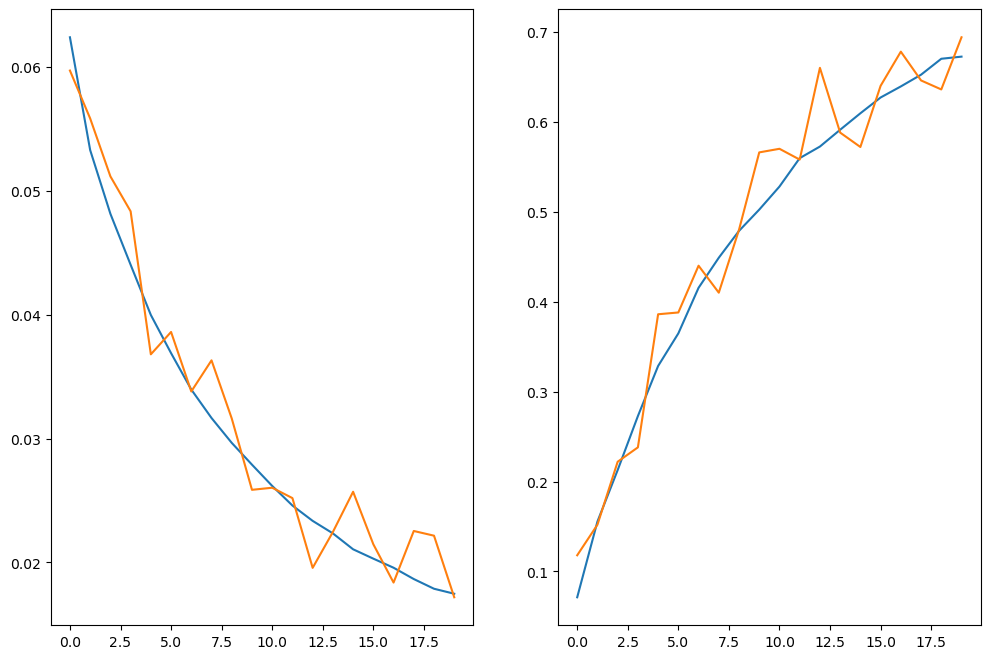

In [18]:
train(model, train_loader, valid_loader, epochs=20, lr=1e-3, save_file_name="augmented")

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


Loss: 0.014969
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.75      0.60      0.67         5
           2       0.80      0.80      0.80         5
           3       0.80      0.80      0.80         5
           4       0.67      0.80      0.73         5
           5       0.80      0.80      0.80         5
           6       1.00      0.60      0.75         5
           7       0.75      0.60      0.67         5
           8       0.80      0.80      0.80         5
           9       0.33      0.40      0.36         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      0.40      0.57         5
          13       0.80      0.80      0.80         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         5
          16       0.71      1.00      0.83         5
          17

<Figure size 1600x1600 with 0 Axes>

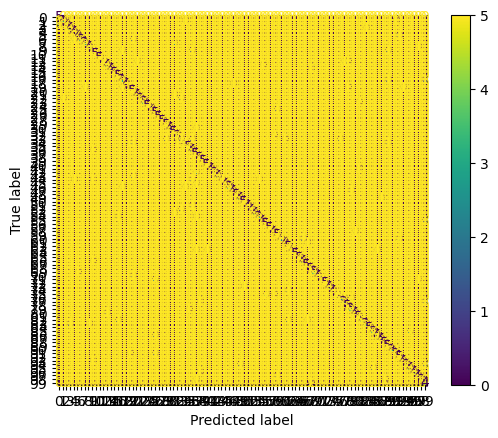

In [19]:
model.load_state_dict(torch.load("models/global_best.pt"))
test(model, test_loader)

## Comparison

The first simple model was a good starting point, however it failed to generalize well to the validation and testing datasets showing clear overfitting. To address this problem I tried regularization via the Global Average Pooling once as a transition from cnn to linears, and another time as replacment to every Max Pooling. Lastly I tried to do data augmentation to help for generalization. During experiments, I also tried adjusting batch sizes, however that should little to no difference except for vram usage. Tweaking the learning rate doesn't help much, it only comes down to if the model is learning or not, and in all the experiments the model was in fact learning.

Overall, the best trained model was the single global averge pooling one without data augmenation (second experiment) showing results of 77% in the testing dataset. These were the same results for the data augmented one, except data loading is slower when having to do augmentations. The best model's weights can be found in "models/global_best.pt"